In [1]:
#| default_exp core

In [2]:
#| export
import kagglehub
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from IPython.display import SVG

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# svg_constraints = kagglehub.package_import('metric/svg-constraints')
    
class Model:
    def __init__(self):
        self.model_path = kagglehub.model_download("google/gemma-2/transformers/gemma-2-2b-it")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_path,
            device_map="auto",
            torch_dtype=torch.bfloat16,)
        self.prompt_template = self.prompt_template = """Generate a valid and complete SVG code using given <description>. The output must be started with <svg> element and ended with </svg> element. Use only the following allowed elements and attributes:
        
        <allowed_elements>: dict[str, set[str]] = {
            'common': {
                'id', 'clip-path', 'clip-rule', 'color', 'color-interpolation', 'color-interpolation-filters',
                'color-rendering', 'display', 'fill', 'fill-opacity', 'fill-rule', 'filter', 'flood-color',
                'flood-opacity', 'lighting-color', 'marker-end', 'marker-mid', 'marker-start', 'mask', 'opacity',
                'paint-order', 'stop-color', 'stop-opacity', 'stroke', 'stroke-dasharray', 'stroke-dashoffset',
                'stroke-linecap', 'stroke-linejoin', 'stroke-miterlimit', 'stroke-opacity', 'stroke-width', 'transform'
            },
            'svg': {'width', 'height', 'viewBox', 'preserveAspectRatio'},
            'g': {'viewBox'},
            'defs': set(),
            'symbol': {'viewBox', 'x', 'y', 'width', 'height'},
            'use': {'x', 'y', 'width', 'height', 'href'},
            'marker': {'viewBox', 'preserveAspectRatio', 'refX', 'refY', 'markerUnits', 'markerWidth', 'markerHeight', 'orient'},
            'pattern': {'viewBox', 'preserveAspectRatio', 'x', 'y', 'width', 'height', 'patternUnits', 'patternContentUnits', 'patternTransform', 'href'},
            'linearGradient': {'x1', 'x2', 'y1', 'y2', 'gradientUnits', 'gradientTransform', 'spreadMethod', 'href'},
            'radialGradient': {'cx', 'cy', 'r', 'fx', 'fy', 'fr', 'gradientUnits', 'gradientTransform', 'spreadMethod', 'href'},
            'stop': {'offset'},
            'filter': {'x', 'y', 'width', 'height', 'filterUnits', 'primitiveUnits'},
            'feBlend': {'result', 'in', 'in2', 'mode'},
            'feFlood': {'result'},
            'feOffset': {'result', 'in', 'dx', 'dy'},
            'path': {'d'},
            'rect': {'x', 'y', 'width', 'height', 'rx', 'ry'},
            'circle': {'cx', 'cy', 'r'},
            'ellipse': {'cx', 'cy', 'rx', 'ry'},
            'line': {'x1', 'y1', 'x2', 'y2'},
            'polyline': {'points'},
            'polygon': {'points'}
        }
           </allowed_elements>"""
        self.svg_default = '<svg width="100" height="100" viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red" /></svg>'
        # self.constraints = svg_constraints.SVGConstraints()
        pass
        
    def predict(self, prompt: str) -> str:
        formatted_description = f"<description>{prompt}</description>"
        inputs = self.tokenizer(self.prompt_template + formatted_description, return_tensors="pt", max_length = 1024, truncation=True).to(DEVICE)
        
        output = self.model.generate(**inputs, max_new_tokens=900)
        output_decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)

        matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
        svg_code = matches[-1] if matches else self.svg_default
        return svg_code if re.search(r"<(circle|rect|path|polygon|polyline|line|ellipse)\b", svg_code, re.IGNORECASE) else self.svg_default

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


<svg width="500" height="500" viewBox="0 0 500 500" preserveAspectRatio="xMidYMid meet">
  <defs>
    <linearGradient id="moonGradient" x1="0%" x2="100%" y1="0%" y2="100%">
      <stop offset="0%" stop-color="#E6E6FA" />
      <stop offset="100%" stop-color="#C0C0C0" />
    </linearGradient>
  </defs>
  <g transform="translate(250, 250)">
    <path d="M 0 0 L 50 50 L 100 0 L 50 0 Z" fill="url(#moonGradient)" />
  </g>
</svg>


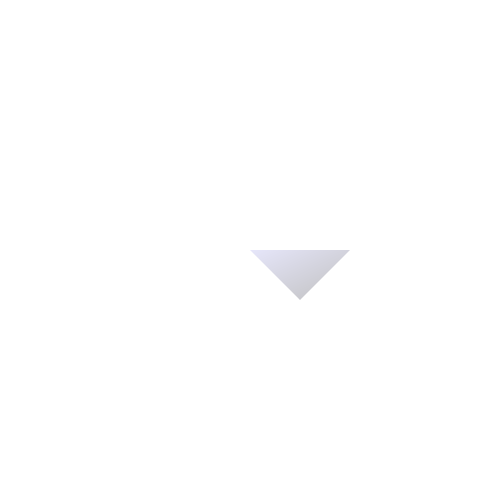

In [3]:
from IPython.display import SVG

model = Model()
svg = model.predict('full moon at night')

print(svg)
display(SVG(svg))